# Finding a maximum entropy (discrete) distribution using the Augmented Lagrangian Method.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cooper-org/cooper/blob/master/docs/source/notebooks/plot_max_entropy_augmented_lagrangian.ipynb)


Here we consider a simple convex optimization problem to illustrate how to use
**Cooper**. This example is inspired by [this StackExchange question](https://datascience.stackexchange.com/questions/107366/how-do-you-solve-strictly-constrained-optimization-problems-with-pytorch):

*I am trying to solve the following problem using Pytorch: given a 6-sided die
whose average roll is known to be 4.5, what is the maximum entropy distribution
for the faces?*

Formally, we want to solve the following optimization problem:

$$
\begin{aligned}
    \max_{p} & -\sum_{i=1}^6 p_i \log p_i \\
    & \sum_{i=1}^6 i p_i = 4.5 \\
    \text{s.t.} & \sum_{i=1}^6 p_i = 1 \\
    & p_i \geq 0 \quad \forall i
\end{aligned}
$$

where $p$ is the probability distribution over the faces of the die.

This tutorial shows how to use the Augmented Lagrangian Method in **Cooper**.

In [1]:
%%capture
# %pip install cooper-optim
%pip install --index-url https://test.pypi.org/simple/ --no-deps cooper-optim  # TODO: Remove this line when cooper deployed to pypi

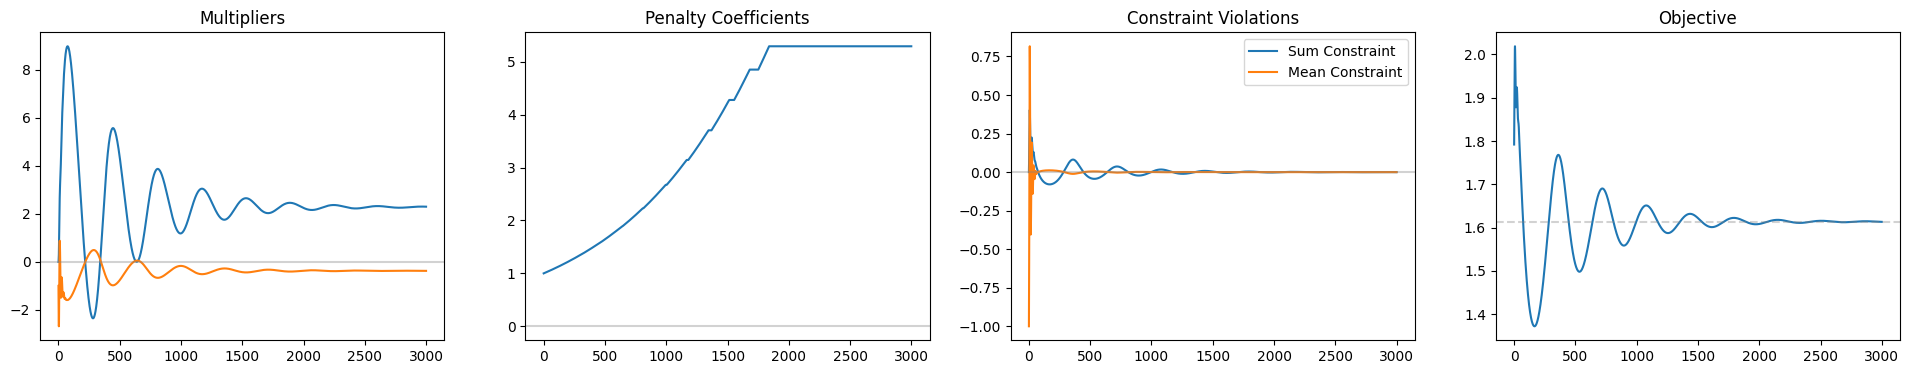

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import cooper
from cooper.multipliers import MultiplicativePenaltyCoefficientUpdater

torch.manual_seed(0)
np.random.seed(0)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MaximumEntropy(cooper.ConstrainedMinimizationProblem):
    def __init__(self, target_mean: float) -> None:
        super().__init__()
        self.target_mean = target_mean

        mean_multiplier = cooper.multipliers.DenseMultiplier(num_constraints=1, device=DEVICE)
        mean_penalty_coefficient = cooper.multipliers.DensePenaltyCoefficient(torch.tensor([1.0], device=DEVICE))
        sum_multiplier = cooper.multipliers.DenseMultiplier(num_constraints=1, device=DEVICE)

        # The mean constraint is solved using an Augmented Lagrangian formulation
        self.mean_constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.EQUALITY,
            formulation_type=cooper.AugmentedLagrangianFormulation,
            multiplier=mean_multiplier,
            penalty_coefficient=mean_penalty_coefficient,
        )

        # For the sum constraint, we use a Lagrangian formulation, without an augmented
        # quadratic penalty term
        self.sum_constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.EQUALITY,
            formulation_type=cooper.LagrangianFormulation,
            multiplier=sum_multiplier,
        )

        # For simple non-negativity constraints, we use projection

    def compute_cmp_state(self, log_probs: torch.Tensor) -> cooper.CMPState:
        probs = torch.exp(log_probs)
        entropy = -torch.sum(probs * log_probs)

        # Equality constraints for proper normalization and mean constraint
        mean = torch.sum(probs * torch.arange(1, len(probs) + 1, device=DEVICE))

        sum_constraint_violation = cooper.ConstraintState(violation=torch.sum(probs) - 1)
        mean_constraint_violation = cooper.ConstraintState(violation=mean - self.target_mean)

        observed_constraints = {
            self.sum_constraint: sum_constraint_violation,
            self.mean_constraint: mean_constraint_violation,
        }

        # Flip loss sign since we want to *maximize* the entropy
        return cooper.CMPState(loss=-entropy, observed_constraints=observed_constraints)


# Define the problem with the constraints
cmp = MaximumEntropy(target_mean=4.5)

# Define the primal parameters and optimizer
log_probs = torch.nn.Parameter(torch.log(torch.ones(6, device=DEVICE) / 6))
primal_optimizer = torch.optim.SGD([log_probs], lr=3e-2)

# Note that Cooper internally scales the dual learning rate for multipliers
# corresponding to Augmented Lagrangian formulations by the penalty coefficient.
#
# Therefore, we need to configure the dual optimizer to SGD(lr=1.0) for recovering the
# updates of the Augmented Lagrangian Method. This leads to the learning rate being the
# same as the value of the penalty coefficient.
dual_optimizer = torch.optim.SGD(cmp.dual_parameters(), lr=1.0, maximize=True)

# The Augmented Lagrangian Method employs alternating updates. Here we choose
# Dual-Primal updates, where the multipliers are updated first, followed by the primal
# parameters.
cooper_optimizer = cooper.optim.AlternatingDualPrimalOptimizer(
    primal_optimizers=primal_optimizer, dual_optimizers=dual_optimizer, cmp=cmp
)

# For the Augmented Lagrangian, we define a scheme to increase the penalty coefficient
# throughout the optimization process. In this tutorial, we use a
# PenaltyCoefficientUpdater from Cooper.
#
# If the constraint does not improve by the given tolerance, the penalty coefficient
# is multiplied by the growth factor.
penalty_updater = MultiplicativePenaltyCoefficientUpdater(growth_factor=1.001, violation_tolerance=1e-4)

state_history = {}
for i in range(3000):
    _, cmp_state, primal_lagrangian_store, _ = cooper_optimizer.roll(compute_cmp_state_kwargs={"log_probs": log_probs})
    penalty_updater.step(cmp_state.observed_constraints)

    observed_violations = list(cmp_state.observed_violations())
    observed_multipliers = list(primal_lagrangian_store.observed_multiplier_values())
    observed_penalty_coefficients = list(primal_lagrangian_store.observed_penalty_coefficient_values())
    state_history[i] = {
        "loss": -cmp_state.loss.item(),
        "multipliers": torch.stack(observed_multipliers).detach(),
        "violation": torch.stack(observed_violations).detach(),
        "penalty_coefficients": torch.stack(observed_penalty_coefficients).detach(),
    }

# Theoretical solution
optimal_prob = torch.tensor([0.05435, 0.07877, 0.1142, 0.1654, 0.2398, 0.3475])
optimal_entropy = -torch.sum(optimal_prob * torch.log(optimal_prob))

# Generate plots
iters, loss_hist, multipliers_hist, violation_hist, penalty_hist = zip(
    *[(k, v["loss"], v["multipliers"], v["violation"], v["penalty_coefficients"]) for k, v in state_history.items()]
)

_, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4))

ax0.plot(iters, torch.stack(multipliers_hist).squeeze().cpu())
ax0.axhline(0.0, c="gray", alpha=0.35)
ax0.set_title("Multipliers")

ax1.plot(iters, torch.stack(penalty_hist).squeeze().cpu())
ax1.axhline(0.0, c="gray", alpha=0.35)
ax1.set_title("Penalty Coefficients")

ax2.plot(iters, torch.stack(violation_hist).squeeze().cpu(), label=["Sum Constraint", "Mean Constraint"])
ax2.legend()
# Show that defect remains below/at zero
ax2.axhline(0.0, c="gray", alpha=0.35)
ax2.set_title("Constraint Violations")

ax3.plot(iters, loss_hist)
# Show optimal entropy is achieved
ax3.axhline(optimal_entropy, c="gray", alpha=0.35, linestyle="dashed")
ax3.set_title("Objective")

plt.show()